# Fair tuning example using Linear setting

#### DGP
The DGP has a linear structural equation for $Y$.

In [1]:
import numpy as np
import pandas as pd
from DGPs.LinearDGP import LinearDGP

constants = {
    'X': 0,
    'Z': 0,
    'W': 0,
    'Y': 0
}
effects = {
    ('U', 'X'): 1, # Unobserved confounder
    ('U', 'Z'): 1, # Unobserved confounder
    ('X', 'W'): 1, # Mediation
    ('Z', 'W'): 0, 
    ('X', 'Y'): -1, # Unwanted effect
    ('Z', 'Y'): 1,
    ('W', 'Y'): 1
}

dgp = LinearDGP(effects, constants)

### Generate data

Training and test data

In [2]:
# Set seed
#np.random.seed(42)
np.random.seed(12)
# Set noise for Y
Y_noise_sd = 5
# Training data
df_train = dgp.generate_data(1000, Y_noise_sd=Y_noise_sd)
X_train = df_train[['X', 'Z', 'W']]
y_train = df_train['Y']

# Evaluation data
df_test = dgp.generate_data(1000, Y_noise_sd=Y_noise_sd)
X_test = df_test[['X', 'Z', 'W']]
y_test = df_test['Y']

Visualize data

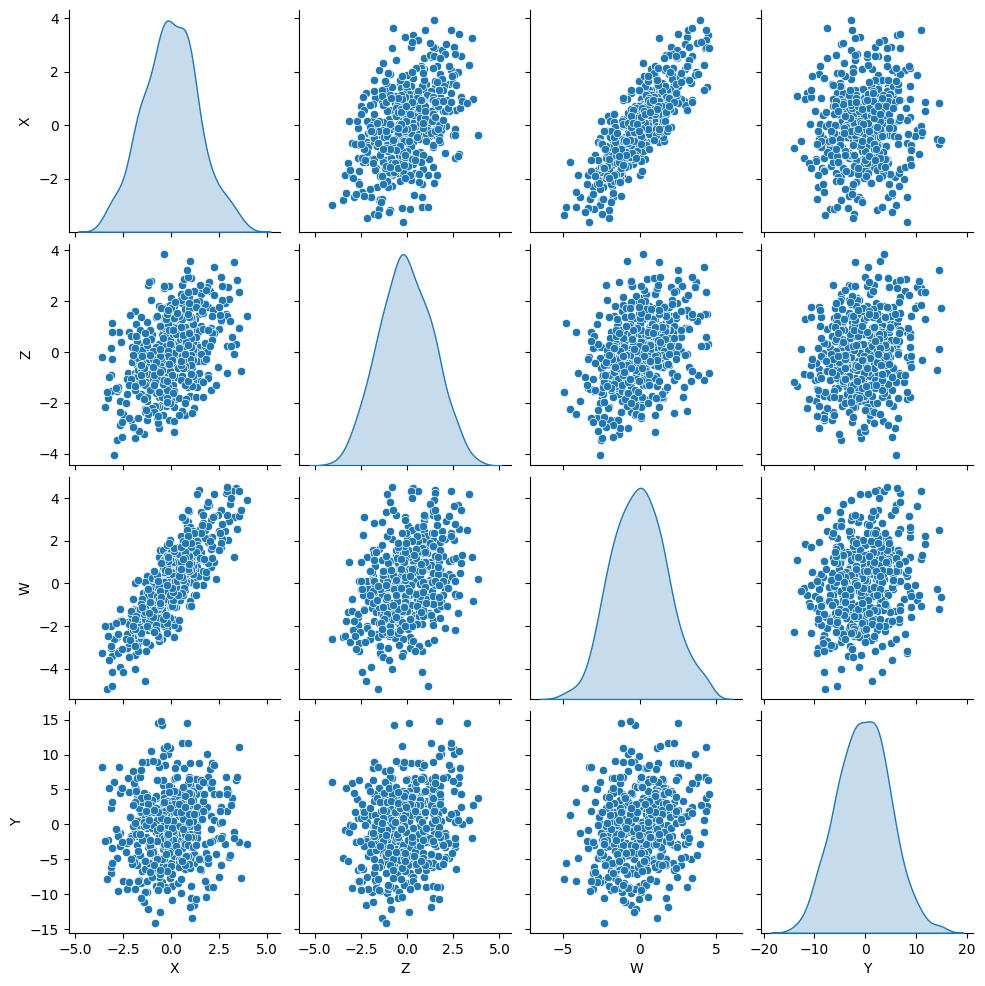

In [3]:
# Plot the training data in a matrix of scatter plots
import seaborn as sns

# Sample 500 data points from the test set
df_test_sample = df_test.sample(500)
sns.pairplot(df_test_sample, diag_kind='kde')

## Models

In [4]:
import torch.nn as nn

n_features = X_train.shape[1]
batch_size = 64
n_epochs_train = 50
n_epochs_tune = 20
hidden_layers = [32, 32]
prediction_criterion = nn.MSELoss()

In [5]:
import torch 
from torch.utils.data import DataLoader, TensorDataset

# Convert the data to PyTorch tensors
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).unsqueeze(1)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).unsqueeze(1)

# Create a DataLoader
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

#### Unconstrained model

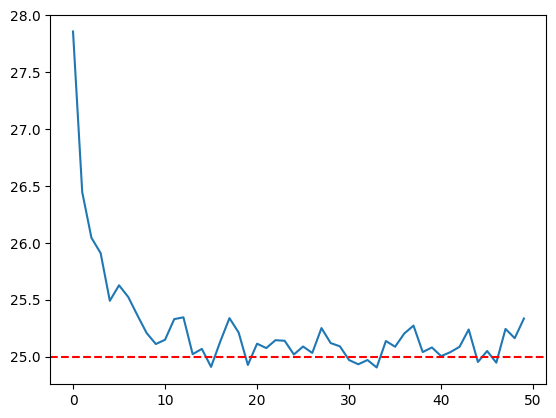

In [6]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt

from Models import NeuralRegressor

unconstrained_model = NeuralRegressor(n_features, hidden_layers=hidden_layers)

# Training
optimizer = optim.Adam(unconstrained_model.parameters(), lr=0.001)
unconstrained_model.train()
unconstrained_losses = []
for epoch in range(n_epochs_train):
    train_loss = 0.0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch, y_batch

        optimizer.zero_grad()
        y_pred = unconstrained_model(X_batch)
        loss = prediction_criterion(y_pred, y_batch)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    # Print epoch training loss
    if (epoch + 1) % 10 == 0:
        print(f'Epoch {epoch+1}/{n_epochs_train}, Training Loss: {train_loss/len(train_loader)}\r', end='')

    # Calculate average loss
    avg_loss = train_loss/len(train_loader)
    
    # Save the loss
    unconstrained_losses.append(avg_loss)
    
unconstrained_model = unconstrained_model.eval()

# Plot the training loss
plt.plot(unconstrained_losses)
# Plot dashed line at Y_noise_sd^2, optimal training loss
plt.axhline(Y_noise_sd**2, color='r', linestyle='--')

### Fair tuning

In [7]:
# Columns to enforce statistical parity
sp_idx = [0]
# Columns to enforce predictive parity
pp_idx = [i for i in range(X_train.shape[1]) if i not in sp_idx] 
# Scaling factor for the fairness constraints
alpha_spd = 10 * Y_noise_sd^2
alpha_ppd = alpha_spd

Creating a training set with gradients

In [8]:
from utils import compute_gradient

# Compute the gradient of the prediction with respect to the input
X_train_with_grad = X_train_tensor.clone().detach().requires_grad_(True)
X_train_gradient = compute_gradient(unconstrained_model, X_train_tensor)
# Create a DataLoader
train_dataset = TensorDataset(X_train_with_grad, X_train_gradient, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

### Fair Tuning

Epoch 20/20 | Total Loss: 31.3361 | SP Loss: 0.0181 | PP Loss: 0.0709 | Prediction Loss: 27.0666

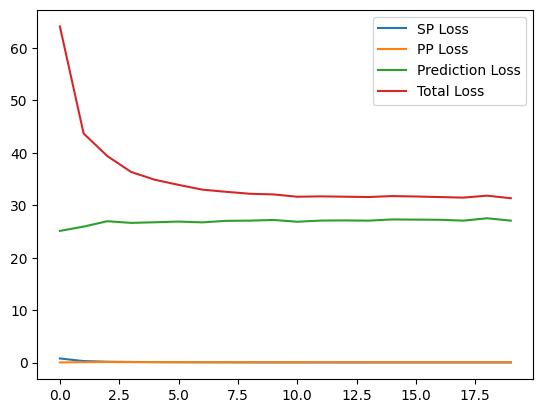

In [9]:
from fair_tuning import fair_tuning

# Create the model
fair_tuned_model = NeuralRegressor(n_features=n_features, hidden_layers=hidden_layers)

# Clone the weights from the unconstrained model
fair_tuned_model.load_state_dict(unconstrained_model.state_dict())
optimizer = optim.Adam(fair_tuned_model.parameters(), lr=0.001)
fair_tuned_model, fair_tuned_losses = fair_tuning(
    target_model=fair_tuned_model,
    train_loader=train_loader,
    optimizer=optimizer,
    prediction_criterion=prediction_criterion,
    sp_idx=sp_idx,
    pp_idx=pp_idx,
    n_epochs=n_epochs_tune,
    alpha_spd=alpha_spd,
    alpha_ppd=alpha_ppd, # Setting PPD scaling to alpha_ppd
    verbose=True
)

fair_tuned_model = fair_tuned_model.eval()

# Plot the training loss
plt.plot(fair_tuned_losses['sp'], label='SP Loss')
plt.plot(fair_tuned_losses['pp'], label='PP Loss')
plt.plot(fair_tuned_losses['prediction'], label='Prediction Loss')
plt.plot(fair_tuned_losses['total'], label='Total Loss')
plt.legend()
plt.show()

## Evaluation

In [10]:
models = {
    'Unconstrained': unconstrained_model,
    'Fair tuned': fair_tuned_model
}

results = pd.DataFrame()
for key, model in models.items():

    # Generate training predictions
    pred_train = model(X_train_tensor).detach().numpy()
    # Generate predictions
    pred = model(X_test_tensor).detach().numpy()
    # Compute gradients
    gradients = compute_gradient(model, X_test_tensor)
    
    # Combine into results
    model_results = df_test[['X', 'Z', 'W', 'Y']].copy()
    model_results['Y_train'] = y_train
    model_results['dX'] = gradients[:, 0]
    model_results['dZ'] = gradients[:, 1]
    model_results['dW'] = gradients[:, 2]
    model_results['pred'] = pred
    model_results['train_pred'] = pred_train
    model_results['model'] = key
    
    results = pd.concat([results, model_results], axis=0, ignore_index=True)


### Gradients

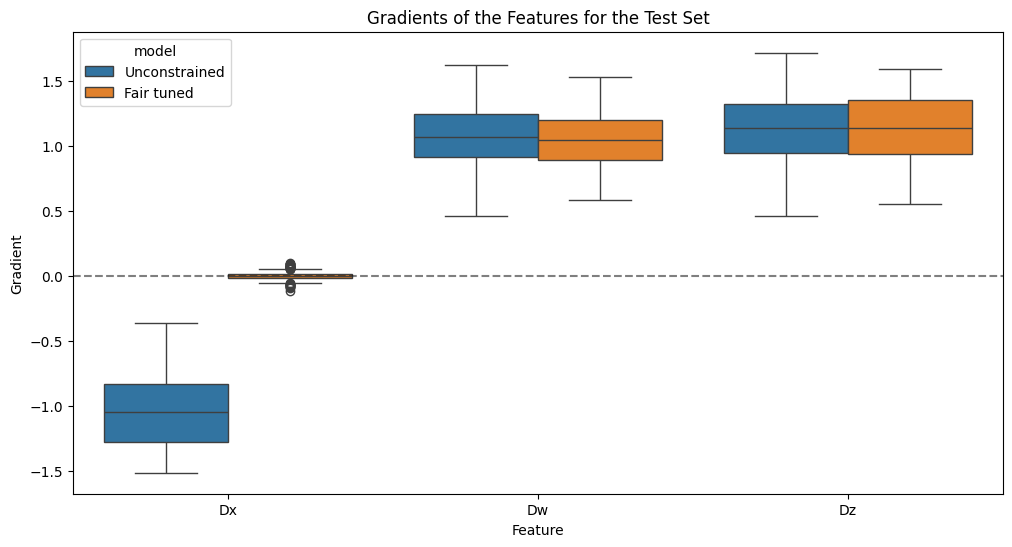

In [13]:
# Plot the gradients using seaborn
import seaborn as sns

# Melt the DataFrame
gradients_melted = results[['model', 'dX', 'dW', 'dZ']].melt(id_vars='model', var_name='Feature', value_name='Gradient')

# Clean up the feature names
gradients_melted['Feature'] = gradients_melted['Feature'].str.replace('_', ' ').str.title()
# Make the first letter uppercase
gradients_melted['Feature'] = gradients_melted['Feature'].str.title()

# Plot the gradients
plt.figure(figsize=(12, 6))
sns.boxplot(data=gradients_melted, x='Feature', y='Gradient', hue='model', dodge=True)
plt.axhline(0, color='black', linestyle='--', alpha=0.5)
plt.title("Gradients of the Features for the Test Set")
plt.show()

Visual inspeciton of gradients

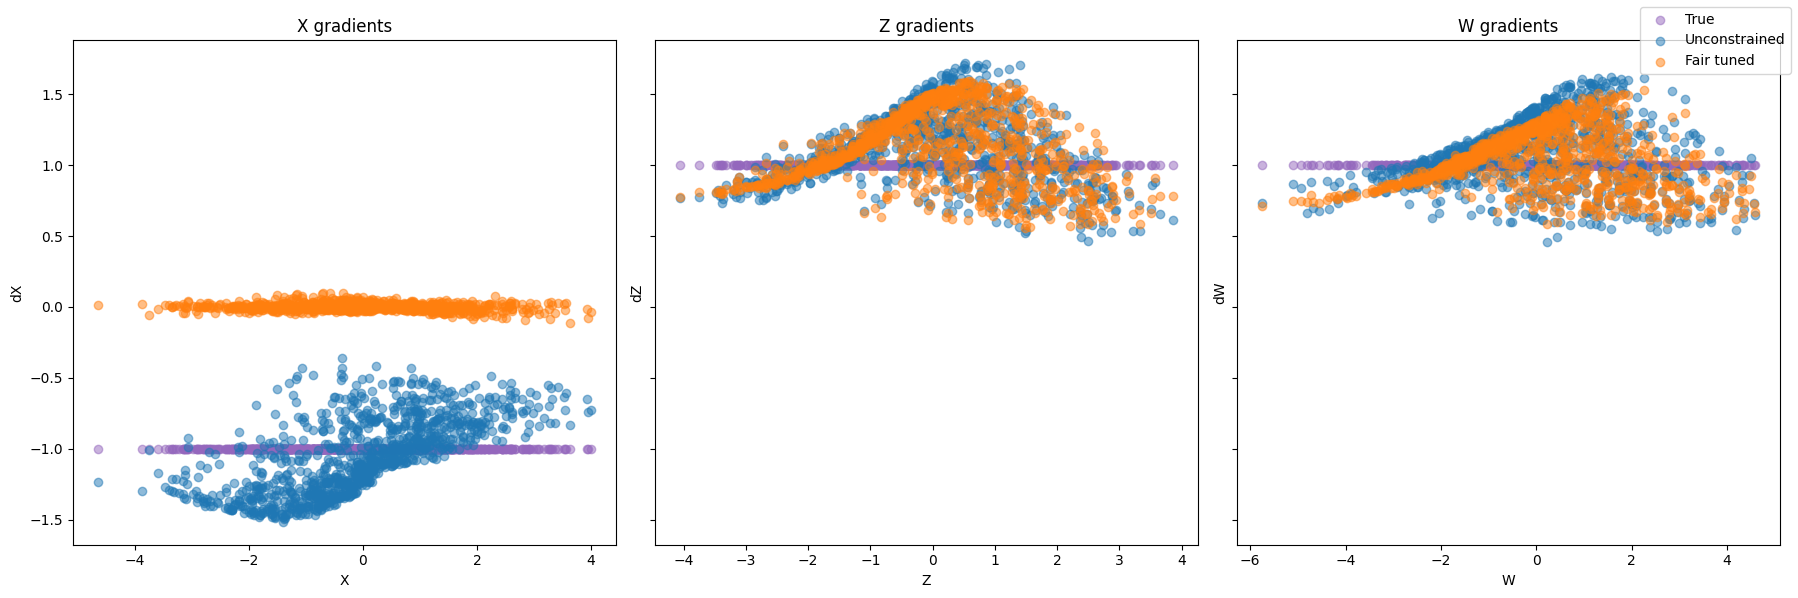

In [12]:
# Loop over specified columns and models
columns = ['X', 'Z', 'W']

gradient_dgp = dgp.compute_gradient(df_test)
gradient_dgp = pd.DataFrame(gradient_dgp, columns=['dX', 'dZ', 'dW'])
fig, axes = plt.subplots(1, len(columns), figsize=(18, 6), sharey=True)
for idx, col in enumerate(columns):
    ax = axes[idx]  # Select the corresponding subplot

    ax.scatter(
        df_test[col], 
        gradient_dgp[f'd{col}'],
        alpha=0.5,
        label='True',
        color='tab:purple'
    )
    
    for model in models:
        ax.scatter(
            results[results['model'] == model][col], 
            results[results['model'] == model][f'd{col}'],
            alpha=0.5,
            label=model
        )
    
    ax.set_xlabel(col)
    ax.set_ylabel(f'd{col}')
    ax.set_title(f'{col} gradients')

# Add a single legend outside the plots
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right')

plt.tight_layout()
plt.show()
